### Diffusion Models from Scratch

We're going to try that in this notebook, beginning with a `toy` diffusion model to see how the different pieces work, and see out the implementation.

**We will look at building**

- The corruption process
- What a UNet is, and how to implement an extremely minimal one from scartch
- Diffusion Model Training
- Sampling Theory

#### Setup and Imports:

In [22]:
import torch
import torchvision
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt


#### The Data

Here I'm using `MNIST/` cause mainly I'm GPU Poor. And easy for building a Toy-Diffusion Model

In [3]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

In [4]:
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

Input Shape: torch.Size([4, 1, 28, 28])
Labels: torch.Size([4])


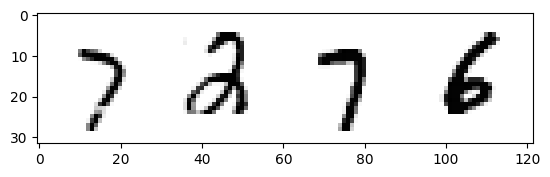

In [5]:
x, y = next(iter(train_dataloader))
print("Input Shape:", x.shape)
print('Labels:', y.shape)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

*Each Image is a greyscale 28px by 28px drawing of a digit, with values ranging from 0 to 1*

#### The Corruption Process

**How to add Noise**

We probably want an easy way to control the amount of corruption. So what if we take in a parameter for the `amount` of noise to add, and then we do:

<div align="center" style="font-size: 1.2em; padding: 20px; border: 1px solid #ccc; border-radius: 5px;">

```python
noise = torch.rand_like(x)

noisy_x = (1-amount)*x + amount*noise
```

</div>

*We can implement this fairly easily, We can get back noise with no trace of input x. By mixing the input with noise this way, we keep the output in the same range (0 to 1)*

In [6]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # sorting shape so broadcasting works
    return x * (1 - amount) + noise * amount

*Inferencing the Results*


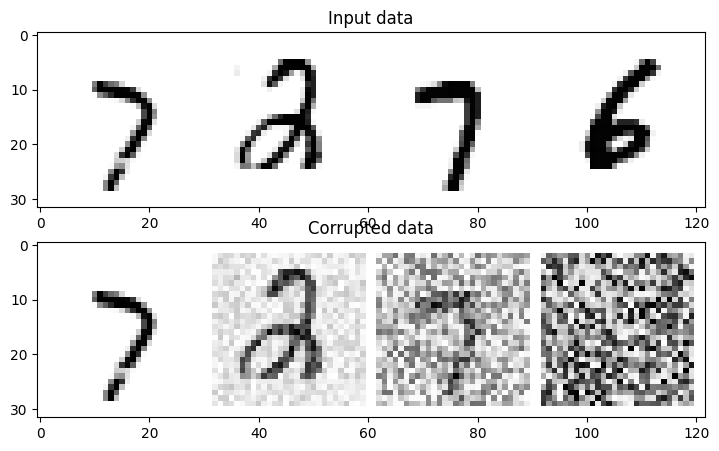

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding Noise
amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

# Plotting
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')

## UNet Architecture for DDPM

We will use a **UNet** as the denoiser inside a DDPM. At each training step we feed the model a noised image $x_t$ and the corresponding diffusion timestep $t$, and the model predicts the noise $\epsilon_\theta(x_t, t)$ that was added. For MNIST, images are single-channel greyscale of shape $(B, 1, 28, 28)$, so the model input and output have the same spatial shape.

### Model Input/Output Specification

**Input**: 
- Noisy image $x_t$ with shape $(B, 1, 28, 28)$ 
- Timestep $t$ (embedded with a sinusoidal/time embedding)
- *Optionally*: class embedding for conditional generation (we keep it unconditional here)

**Output**: 
- Predicted noise $\hat{\epsilon}$ with the same shape as $x_t$

During training, we minimize the MSE between $\hat{\epsilon}$ and the true noise $\epsilon$ used to corrupt the clean image:

$$\mathcal{L} = \mathbb{E}_{t, x_0, \epsilon} \left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]$$

### Why UNet?

A UNet has a **contracting path** (downsampling encoder) that captures global context and an **expanding path** (upsampling decoder) that reconstructs fine details. **Skip connections** bridge encoder and decoder stages so that high-frequency details lost during downsampling can be reintroduced during upsampling—crucial for sharp samples.

### Architecture Overview (MNIST-friendly UNet)

#### Encoder (Contracting Path)
- Repeated blocks of: $\text{Conv} \rightarrow \text{Norm} \rightarrow \text{ReLU}$
- Downsampling between blocks (e.g., strided convolution)
- Channel count grows as resolution shrinks: $1 \rightarrow 32 \rightarrow 64 \rightarrow 128$

#### Bottleneck
- Few residual/attention blocks at the smallest resolution
- Captures global context at $7 \times 7$ or $14 \times 14$ resolution

#### Decoder (Expanding Path)
- Symmetric upsampling blocks (transpose convolution or interpolation)
- Each decoder block concatenated with corresponding encoder feature map via **skip connections**
- Gradually reduces channels back to 1: $128 \rightarrow 64 \rightarrow 32 \rightarrow 1$

#### Timestep Conditioning
A learned embedding of $t$ is injected into residual blocks:
$$h_{t+1} = h_t + \text{MLP}(\text{TimeEmbed}(t))$$

This tells the network how much denoising to perform at each step.

### Implementation Details

**Shape Consistency**: Input and output maintain $(B, 1, 28, 28)$ throughout the process.

**Computational Efficiency**: Light enough for MNIST while illustrating the full DDPM pipeline.

**Framework**: We use `diffusers.UNet2DModel` for compact implementation and `DDPMScheduler` for noise scheduling.

### Training vs. Sampling

- **Training**: UNet learns to predict noise $\epsilon$ given $(x_t, t)$
- **Sampling**: Iteratively removes predicted noise from pure Gaussian noise:
  $$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t, t)\right) + \sigma_t z$$

where $z \sim \mathcal{N}(0, I)$ and the scheduler defines $\{\alpha_t, \beta_t, \bar{\alpha}_t\}$.


<div style='text-align: center;'>
    <h2> Architecture of UNet </h2>
<div>

<div style="text-align: center;">
   <img src="assests/image.png" alt="Image Description" width="50%">
</div>


In [10]:
class BasicUnet(nn.Module):
    '''A Basic Unet Implementations'''
    
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size = 5, padding = 2),
                nn.Conv2d(64, 64, kernel_size = 5, padding = 2),
            ]
        )
        
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size = 5, padding=2),
                nn.Conv2d(64, 32, kernel_size = 5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size = 5, padding=2),
            ]
        )
        
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
        
    
    def forward(self, x):
        h = []

        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)
                
        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))
            
        return x 

In [11]:
net = BasicUnet()
x = torch.randn(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

### Training the network:

We can now train the network:

- Get a batch of data
- Corrupt it by random amounts
- Feed it through the model
- Compare the model predictions with the clean images to calculate our loss
- Update the model's parameters accordingly

Epoch 1/10: 100%|██████████| 3750/3750 [00:27<00:00, 137.75it/s]


finished epoch 0. Average Loss: 0.025


Epoch 2/10: 100%|██████████| 3750/3750 [00:25<00:00, 148.41it/s]


finished epoch 1. Average Loss: 0.020


Epoch 3/10: 100%|██████████| 3750/3750 [00:25<00:00, 149.67it/s]


finished epoch 2. Average Loss: 0.019


Epoch 4/10: 100%|██████████| 3750/3750 [00:27<00:00, 134.12it/s]


finished epoch 3. Average Loss: 0.018


Epoch 5/10: 100%|██████████| 3750/3750 [00:27<00:00, 137.43it/s]


finished epoch 4. Average Loss: 0.017


Epoch 6/10: 100%|██████████| 3750/3750 [00:28<00:00, 130.36it/s]


finished epoch 5. Average Loss: 0.017


Epoch 7/10: 100%|██████████| 3750/3750 [00:29<00:00, 125.79it/s]


finished epoch 6. Average Loss: 0.017


Epoch 8/10: 100%|██████████| 3750/3750 [00:26<00:00, 139.61it/s]


finished epoch 7. Average Loss: 0.017


Epoch 9/10: 100%|██████████| 3750/3750 [00:27<00:00, 136.46it/s]


finished epoch 8. Average Loss: 0.016


Epoch 10/10: 100%|██████████| 3750/3750 [00:26<00:00, 140.32it/s]

finished epoch 9. Average Loss: 0.016


(0.0, 0.1)

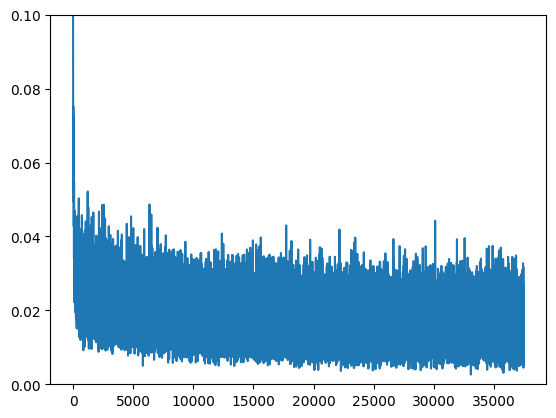

In [23]:
from tqdm import tqdm

batch_size = 16
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 10

# Create a Instance of Unet:
net = BasicUnet()
net.to(device)

loss_fn = nn.MSELoss()

# The Optimizer:
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

losses = []

for epoch in range(n_epochs):
    
    for x, y in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0], device=device)
        noisy_x = corrupt(x, noise_amount)
        
        pred = net(noisy_x)
        
        loss = loss_fn(pred, x)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"finished epoch {epoch}. Average Loss: {avg_loss:.3f}")

plt.plot(losses)
plt.ylim(0, 0.1)


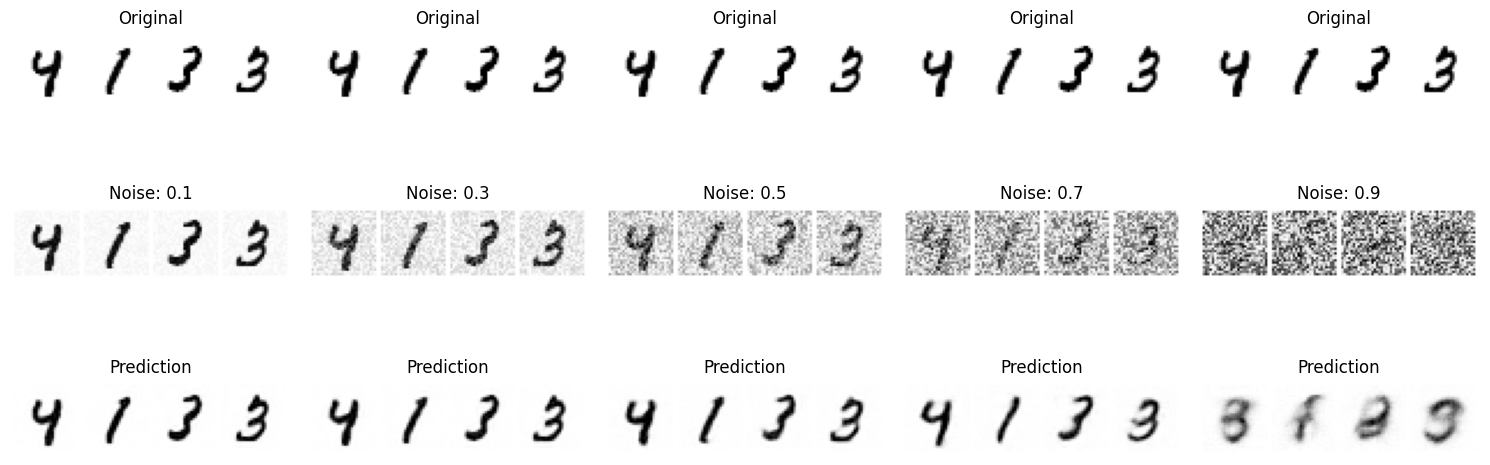


Prediction quality (MSE) at different noise levels:
Noise level 0.1: MSE = 0.0020
Noise level 0.3: MSE = 0.0030
Noise level 0.5: MSE = 0.0071
Noise level 0.7: MSE = 0.0178
Noise level 0.9: MSE = 0.0601


In [30]:
# Get a fresh batch
x, y = next(iter(train_dataloader))
x = x.to(device)

# Test with different noise levels
noise_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
fig, axs = plt.subplots(3, len(noise_levels), figsize=(15, 6))

for i, noise_level in enumerate(noise_levels):
    # Create noise
    amount = torch.full((x.shape[0],), noise_level).to(device)
    noised_x = corrupt(x, amount)
    
    # Get prediction
    with torch.no_grad():
        pred = net(noised_x)
    
    # Move to CPU for visualization
    x_cpu = x.cpu()
    noised_x_cpu = noised_x.cpu()
    pred_cpu = pred.cpu()
    
    # Plot
    axs[0, i].imshow(torchvision.utils.make_grid(x_cpu[:4])[0].clip(0, 1), cmap="Greys")
    axs[0, i].set_title(f"Original")
    axs[0, i].axis('off')
    
    axs[1, i].imshow(torchvision.utils.make_grid(noised_x_cpu[:4])[0].clip(0, 1), cmap="Greys")
    axs[1, i].set_title(f"Noise: {noise_level}")
    axs[1, i].axis('off')
    
    axs[2, i].imshow(torchvision.utils.make_grid(pred_cpu[:4])[0].clip(0, 1), cmap="Greys")
    axs[2, i].set_title(f"Prediction")
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

# Calculate and print MSE for different noise levels
print("\nPrediction quality (MSE) at different noise levels:")
for noise_level in noise_levels:
    amount = torch.full((x.shape[0],), noise_level).to(device)
    noised_x = corrupt(x, amount)
    
    with torch.no_grad():
        pred = net(noised_x)
    
    mse = F.mse_loss(pred, x).item()
    print(f"Noise level {noise_level}: MSE = {mse:.4f}")


### Sampling Process in Diffusion Models

The sampling process reverses the forward diffusion by iteratively denoising pure Gaussian noise to generate new images.


**Forward Process (Training)**
$$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t I)$$

**Reverse Process (Sampling)**
$$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 I)$$

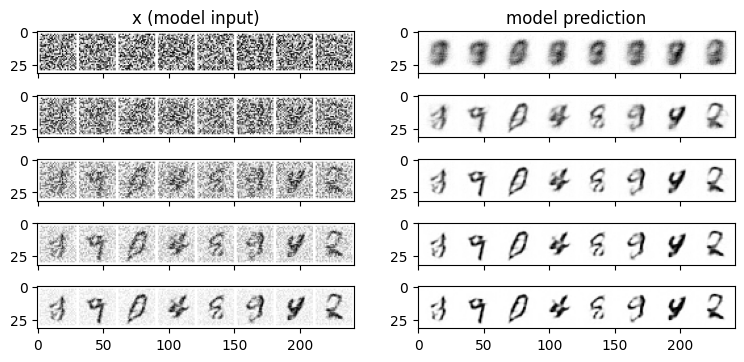

In [31]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = net(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")

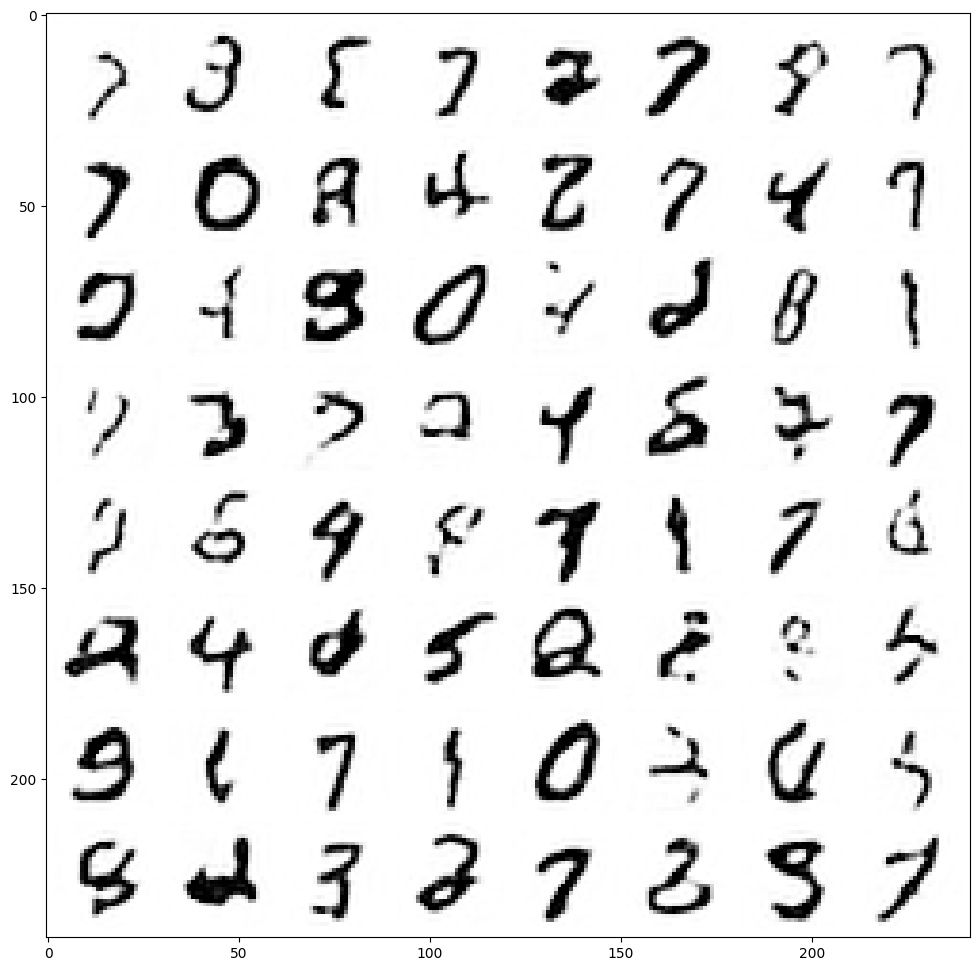

In [32]:
# @markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")